# Person - feature engineering

In [1]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

### Load dataset

In [31]:
object_detections = pd.read_csv('../Datasets/Person_no_outliers__2019-09-09_2020-03-02.csv')
print(object_detections.shape)
object_detections.head(2)

(4079, 3)


,date,hour,obs_count
0,2019-09-09,0,0
1,2019-09-09,1,0


### Discuss approach

Even though the dataset above looks very simple, we can not forget how difficult it was to collect it and prepare for further processing.

Based on the date column alone we can extract some interesting features, like:
- month
- week number
- is it a weekend day

Then the idea is to connect it with the weather data extracted from the Dark Sky API.

Once all the features are prepared, we can save the dataset again and move on to another Notebook, where we will create a prediction model, which will predict an object count for a given date and weather situation.

In [32]:
# add date-time related features
object_detections['date'] = pd.to_datetime(object_detections['date'])
object_detections['n_month'] = object_detections['date'].dt.month
object_detections['n_week_in_month'] = (object_detections['date'].dt.day-1)//7+1
object_detections['day_of_week'] = object_detections['date'].dt.dayofweek
object_detections['day_of_week_name'] = object_detections['date'].dt.weekday_name
object_detections['is_weekend_day'] = ((object_detections['date'].dt.dayofweek) // 5 == 1).astype(int)
object_detections.head(2)

,date,hour,obs_count,n_month,n_week_in_month,day_of_week,day_of_week_name,is_weekend_day
0,2019-09-09,0,0,9,2,0,Monday,0
1,2019-09-09,1,0,9,2,0,Monday,0


In [33]:
# load weather data
weather = pd.read_csv('../Datasets/dark_sky_data_2019-09-09_2020-03-02.csv')
weather.head(2)

,ts,dt,cur__summary,cur__precipIntensity,cur__precipProbability,cur__precipType,cur__temperature,cur__apparentTemperature,cur__humidity,cur__windSpeed,cur__windGust,cur__windBearing,cur__cloudCover,cur__uvIndex,cur__visibility,daily__summary,daily__sunriseTime,daily__sunsetTime,daily__temperatureHigh,daily__temperatureLow
0,1567985400,2019-09-09 00:30:00,Possible Light Rain,0.7929,0.47,rain,14.06,14.08,0.96,21.30,35.13,241,0.99,0,10.796,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01
1,1567989000,2019-09-09 01:30:00,Possible Light Rain,0.8310,0.45,rain,13.99,13.99,0.93,22.49,35.87,215,0.96,0,10.945,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01


In [34]:
# add date-time related features, so we can merge the datasets together
weather['dt'] = pd.to_datetime(weather['dt'])
weather['date'] = weather['dt'].dt.date
weather['date'] = pd.to_datetime(weather['date'])
weather['hour'] = weather['dt'].dt.hour

check_cols = ['dt', 'date', 'hour']
weather[check_cols].head(2)

,dt,date,hour
0,2019-09-09 00:30:00,2019-09-09,0
1,2019-09-09 01:30:00,2019-09-09,1


In [35]:
# join detections and weather data
merged = object_detections.merge(weather, on=['date', 'hour'])

In [36]:
# make sure that we have not lost any observations
assert object_detections.shape[0] == merged.shape[0]

#### How good are the features?

Now that we have merged the counts and weather datasets, we can explore the relationships in the data.

In [69]:
merged.head(2)

,date,hour,obs_count,n_month,n_week_in_month,day_of_week,day_of_week_name,is_weekend_day,ts,dt,cur__summary,cur__precipIntensity,cur__precipProbability,cur__precipType,cur__temperature,cur__apparentTemperature,cur__humidity,cur__windSpeed,cur__windGust,cur__windBearing,cur__cloudCover,cur__uvIndex,cur__visibility,daily__summary,daily__sunriseTime,daily__sunsetTime,daily__temperatureHigh,daily__temperatureLow
0,2019-09-09,0,0,9,2,0,Monday,0,1567985400,2019-09-09 00:30:00,Possible Light Rain,0.7929,0.47,rain,14.06,14.08,0.96,21.30,35.13,241,0.99,0,10.796,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01
1,2019-09-09,1,0,9,2,0,Monday,0,1567989000,2019-09-09 01:30:00,Possible Light Rain,0.8310,0.45,rain,13.99,13.99,0.93,22.49,35.87,215,0.96,0,10.945,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01


In [75]:
def hr_range(from_hr, to_hr):
    idx = (merged['hour'] >= from_hr) & (merged['hour'] <= to_hr)
    return merged.loc[idx]

In the morning hours, it should be much more quiet during the weekends.

This can be observed in the plot below, from 6AM to 9AM, there is much higher probability to see nothing for an hour over the weekend.

It makes sense as people tend to sleep longer.

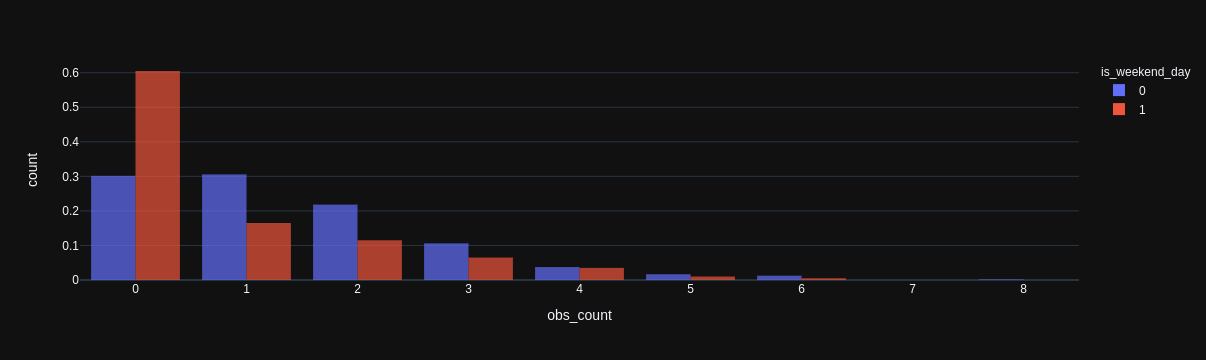

In [78]:
px.histogram(hr_range(6,9), x="obs_count", color="is_weekend_day", opacity=0.7,
             barmode='group', height=300, histnorm='probability density')

On the contrary, during the afternoon hours people tend to walk more, so there should be much lower probability to see nothing over the weekends.

Again, the plot below shows the count distribution between 1PM and 4PM:

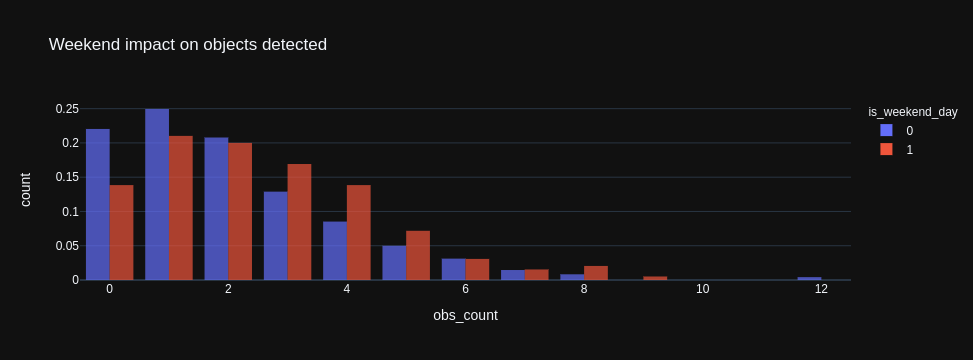

In [105]:
px.histogram(hr_range(13,16), x="obs_count", color="is_weekend_day", opacity=0.7,
             barmode='group', height=300, histnorm='probability density',
             title='Weekend impact on objects detected')

Does bad weather have an impact on the number of objects?

In [93]:
# define 3 categories of weather: Good, Bad and Perfect
merged['cur_weather_type'] = 'Good'
perfect_idx = merged['cur__summary'] == 'Clear'
merged.loc[perfect_idx, 'cur_weather_type'] = 'Perfect'
bad_weather_words = ['drizzle', 'rain', 'danger']
bad_idx = merged['cur__summary'].str.contains("|".join(bad_weather_words), case=False)
merged.loc[bad_idx, 'cur_weather_type'] = 'Bad'

As can be seen in the plot below, when weather is bad (during the day) there are more time intervals without any objects detected.

It can be seen clearly during afternoon hours, as seen below. There is a probability of 36% that there will be 0 objects if weather is bad, but if weather is perfect (clear skies), that probability is only 25%. 

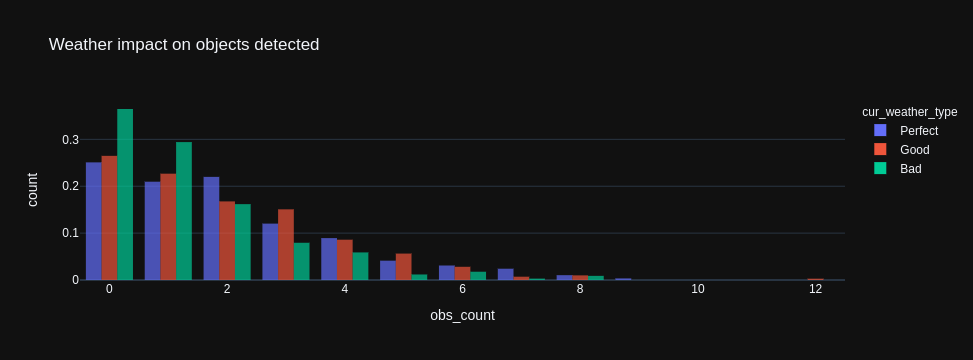

In [104]:
px.histogram(hr_range(12,19), x="obs_count", color="cur_weather_type", opacity=0.7,
             barmode='group', height=300, histnorm='probability density',
             title='Weather impact on objects detected')

Does gust speed affect the number of objects detected in the hourly time intervals?

In [127]:
# define 3 categories of gusts: Low, Medium and Strong
merged['gust_strength'] = 'Low'
idx = merged['cur__windGust'] >= 40
merged.loc[idx, 'gust_strength'] = 'Medium'
idx = merged['cur__windGust'] >= 60
merged.loc[idx, 'gust_strength'] = 'Strong'

If we look closer at the grouped histogram below, we observe that when gust speed is over a value of 60, there is a probability of 33% of seeing no objects, where the probability is 26% of seeing no objects when gust speed is low or medium.

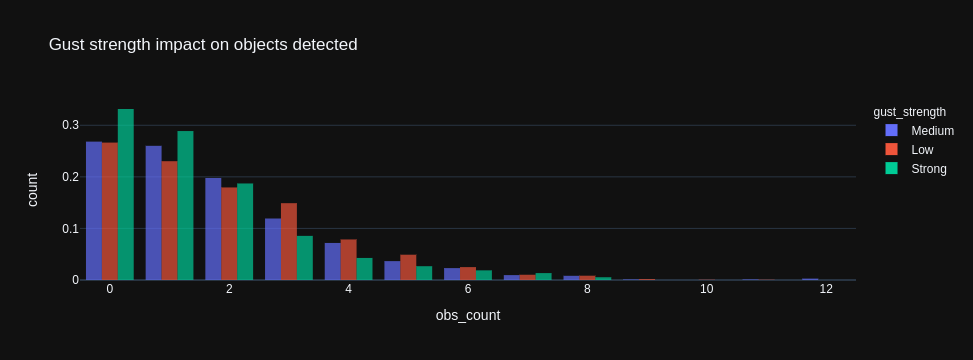

In [134]:
px.histogram(hr_range(7,19), x="obs_count", color="gust_strength", opacity=0.7,
             barmode='group', height=300, histnorm='probability density',
             title='Gust strength impact on objects detected')

The above plots are using the probability density, however if we look at the number of observations for each category, the plot begins to looks quite diffrently.

There is a big difference in the count of observations with strong gusts, and we will see in the forecasting step if addign this feature is actually beneficial for the accuracy of the prediction model.

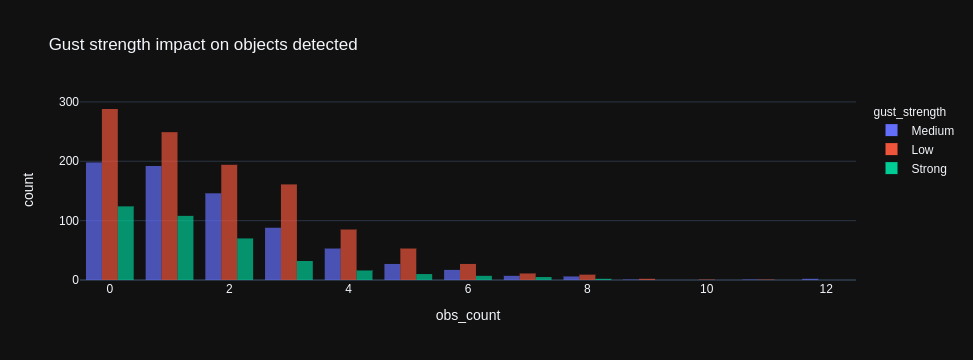

In [132]:
px.histogram(hr_range(7,19), x="obs_count", color="gust_strength",
             opacity=0.7, barmode='group', height=300,
             title='Gust strength impact on objects detected')

In [140]:
merged.head(2)

,date,hour,obs_count,n_month,n_week_in_month,day_of_week,day_of_week_name,is_weekend_day,ts,dt,cur__summary,cur__precipIntensity,cur__precipProbability,cur__precipType,cur__temperature,cur__apparentTemperature,cur__humidity,cur__windSpeed,cur__windGust,cur__windBearing,cur__cloudCover,cur__uvIndex,cur__visibility,daily__summary,daily__sunriseTime,daily__sunsetTime,daily__temperatureHigh,daily__temperatureLow,cur_weather_type,gust_strength
0,2019-09-09,0,0,9,2,0,Monday,0,1567985400,2019-09-09 00:30:00,Possible Light Rain,0.7929,0.47,rain,14.06,14.08,0.96,21.30,35.13,241,0.99,0,10.796,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01,Bad,Low
1,2019-09-09,1,0,9,2,0,Monday,0,1567989000,2019-09-09 01:30:00,Possible Light Rain,0.8310,0.45,rain,13.99,13.99,0.93,22.49,35.87,215,0.96,0,10.945,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01,Bad,Low


In [141]:
# select most promising features and save as csv
keep_cols = ['date', 'hour', 'obs_count', 'n_month', 'n_week_in_month', 
             'is_weekend_day', 'cur__precipIntensity', 'cur_weather_type',
             'cur__windSpeed', 'cur__windGust', 'gust_strength',
             'daily__sunriseTime', 'daily__sunsetTime']
filename = 'Person_no_outliers_feature_eng__2019-09-09_2020-03-02.csv'
merged[keep_cols].to_csv(f'../Datasets/{filename}', index=False)